In [56]:
# Imports and loading data

import pickle
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

with open('../../data/ch1_etfs_valid_pairs.pkl', 'rb') as f:
    valid_pairs = pickle.load(f)

with open('../../data/ch0_etfs.pkl', 'rb') as f:
    df, df_returns = pickle.load(f)

# Forecasting spread and determining trend

Pairs trading requires us to model the returns of a pair of assets. Traditional methods use linear regression to establish a linear relationship between the price series of a pair of assets. Unfortunately, machine learning proves to be a difficult approach to model this relationship.

### Why do we use a linear model?
1. An OLS estimator establishes a linear relationship between the assets solely based on price series. Machine learning applications require extra features and more information regarding the price series individually. This makes it difficult to focus on the spread using machine learning applications. A counter-approach to this problem would be making predictions on the price series individually, which would require extensive research into the factors affecting prices of assets and would surpass the scope of the research question at hand.
2. Our pair selection criteria specifically assumes a mean-reverting, stationary and homoskedastic linear combination of the two price series. By definition, our spread is based on a linear relationship between the two price series. Selecting the pair based on a linear model, then establishing the relationship using a non-linear model would be a faulty approach.

### How do we apply machine learning?
Despite settling on a linear model, there are still areas of exploration for machine learning such as setting the thresholds for trade execution and more importantly predicting the trend of the spread to maximize profits. Predicting the trend of the spread would allow us to take positions with the highest ROI instead of relying on a static threshold. The rest of this document focuses on forecasting the spread to be able to "sell the peak and buy the dip".

### Trend over static thresholds

There are two benefits of relying on trend over static thresholds:
1. We can execute smaller trades even if the spread does not cross the upper or lower threshold.
2. Even if the spread crosses the threshold, we can wait for the trend reversion to execute trades. This would allow us to "hold" until the optimal moment.

### Example

Assume the spread has a mean of 0 and we set our upper and lower thresholds to take positions at 1 and -1 respectively. We "short" the spread when the spread crosses 1 and "long" the spread when it crosses -1. We close positions whenever the spread reverts back to the mean. Imagine a case where we have the following time series for the spread:

| t0 | t1 | t2 | t3 | t4 | t5 | t6 | t7 | t8 |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 0 | 1 | 2 | 3 | 1 | 0 | -1 | -2 | 0 |

1. We "short" the spread at t1 and close the short position at t5 when it reverts back to its mean of 0, resulting in a profit of 1.
2. We "long" the spread at t6 and close the long position at t8 when it reverts back to its mean of 0, resulting in another profit of 1.

**Our total profit is 2.**

Now imagine a case where we predicted the trend changes correctly, that is when the gradient of the price series crosses 0. In simpler terms, when the price series stops going up and starts going down or vice versa. These trend changes occur at t4 and t8 respectively. If we could predict these changes at t3 and t7:
1. We "short" the spread at t3 and close the short position at t5 when it reverts back to its mean of 0, resulting in a profit of 3.
2. We "long" the spread at t7 and close the long position at t8 when it reverts back to its mean of 0, resulting in another profit of 2.

**Our total profit is 5.**

Of course stochastic processes are much more complicated in practice, but the general principle holds.

Imagine another case where the price series oscillates around 0 and between 0.5 and -0.5. Relying on the thresholds, we wouldn't execute any trades resulting in a profit of 0. On the other hand, if we rely on trend changing direction, we would be execute trades at every oscillation resulting in a net positive profit.

One drawback of this approach is that it still does not help with the cases where the spread does not cross its own mean before the next trend change. This is also an issue we will run into while dealing with static tresholds. Another drawback is that predicting the future, especially in financial markets, is **very** difficult :)

# Computing spread

We start by computing the spread based on the price series of the two tickers. We achieve this by fitting the two price series into a linear regression model, the error terms are essentially the spread of our model.

In [57]:
# Compute spread

ticker_1 = valid_pairs[0][0]
ticker_2 = valid_pairs[0][1]

ticker_series_1 = df[ticker_1]
ticker_series_2 = df[ticker_2]
print(ticker_series_1)

slope, intercept, _, _, _ = linregress(ticker_series_1, ticker_series_2)
spread = ticker_series_2 - (slope * ticker_series_1 + intercept)

data = spread.values
print(data)

Timestamp
2019-05-13 04:00:00+00:00    56.55
2019-05-14 04:00:00+00:00    57.20
2019-05-15 04:00:00+00:00    57.38
2019-05-16 04:00:00+00:00    57.67
2019-05-17 04:00:00+00:00    57.15
                             ...  
2022-12-23 05:00:00+00:00    57.98
2022-12-27 05:00:00+00:00    58.31
2022-12-28 05:00:00+00:00    57.54
2022-12-29 05:00:00+00:00    58.48
2022-12-30 05:00:00+00:00    57.88
Name: IXUS, Length: 918, dtype: float64
[-1.54003141e-01 -2.16999713e-01 -2.15675687e-01 -2.31320311e-01
 -2.02923053e-01 -1.29647765e-01 -1.95153032e-01 -1.80031062e-01
 -1.18219158e-01 -1.75431748e-01 -2.30971791e-01 -2.15849822e-01
 -2.47417787e-01 -2.51773163e-01 -1.79787123e-01 -2.26337700e-01
 -2.05292390e-01 -3.05675687e-01 -2.18149604e-01 -2.37348232e-01
 -1.52992857e-01 -1.72226263e-01 -1.82748918e-01 -1.79612988e-01
  6.28505554e-01  6.55125685e-01  6.96589069e-01  6.39515837e-01
  6.63451300e-02  3.70071431e-02  3.72510820e-02  7.38364357e-02
  3.22684706e-02  7.35924968e-02  1.33485580e

# LSTM Encoder Decoder Model Data Preparation

LSTM Encoder Decoder models use a sequence of time series data to project a sequence of forecasted time series. The input length determines the length of the sequence used for prediction and the output length defines how many time periods to predict into the future. We also split our dataset into test and train sets to dodge look-ahead bias and then reshape the data into the format required for the model.

In [58]:
# Normalize data, split train and test, create sequences and reshpae them for model

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

def create_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

input_length = 90
output_length = 3

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

X_train, y_train = create_sequences(train_data, input_length, output_length)
X_test, y_test = create_sequences(test_data, input_length, output_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# Constructing the Model

We construct encoder and decoder cells by utilizing LSTM and dropout layers. LSTM layers produce a set of units / nodes for prediction and the Dropout layers ensure that a certain portion of units are unweighed at each step to prevent overfitting. The encoder then produces a repeat vector for the decoder to process, and the decoder produces the expected output sequence with one feature per time step thanks to the Dense layer. We also utilize an early stopping callback to stop training if there is no meaningful loss following a set number of steps. We plot the training loss and save model evaluation metrics.

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_244 (LSTM)                 │ (None, 90, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_244 (Dropout)           │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_245 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_245 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_61 (RepeatVector) │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_246 (LSTM)                 │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_247 (LSTM)                 │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_247 (Dropout)           │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_61             │ (None, 3, 1)           │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0882 - val_loss: 0.0483
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0281 - val_loss: 0.0402
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0245 - val_loss: 0.0337
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0191 - val_loss: 0.0284
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0193 - val_loss: 0.0262
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0163 - val_loss: 0.0267
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0157 - val_loss: 0.0254
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0136 - val_loss: 0.0232
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0128 - val_loss: 0.0225
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0114 - val_loss: 0.0234
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0137 - val_loss: 0.0225
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

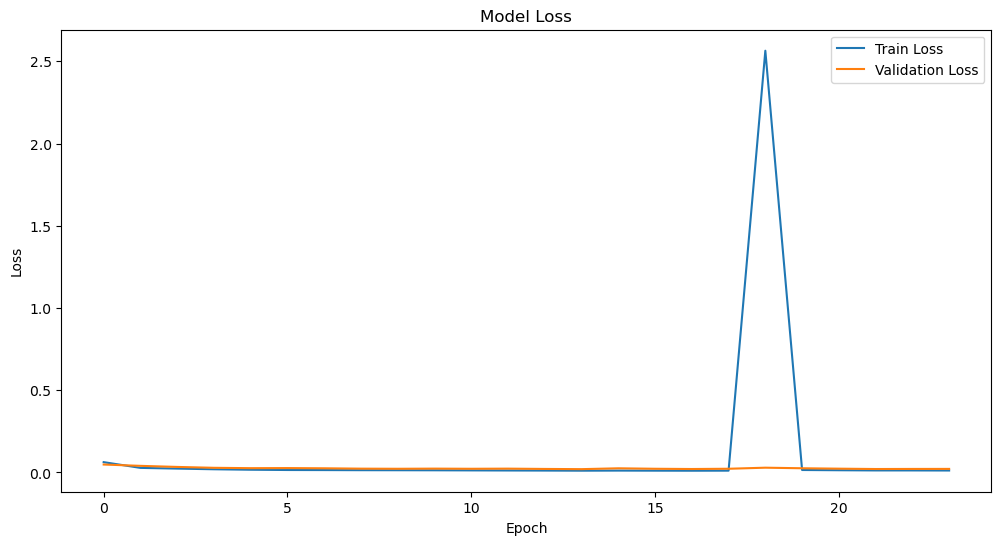

In [59]:
# Construct LSTM Encoder Decoder model

# Encoder

inputs = Input(shape=(input_length, 1))
encoder = LSTM(50, activation='relu', return_sequences=True)(inputs)
encoder = Dropout(0.2)(encoder)
encoder = LSTM(50, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = RepeatVector(output_length)(encoder)

# Decoder

decoder = LSTM(50, activation='relu', return_sequences=True)(encoder)
decoder = Dropout(0.2)(decoder)
decoder = LSTM(50, activation='relu', return_sequences=True)(decoder)
decoder = Dropout(0.2)(decoder)
outputs = TimeDistributed(Dense(1))(decoder)

# Model

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])


test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating Predictions

We make predictions on both the train and test set and compute trend on both the actual values and the predictions. We define trend to be the comparison of the mean of last **n** values in the time series to the next **n** values predicted by the model, where **n** refers to the output length of the model.

We plot actual values vs. predictions as well as moving averages of actual values vs. moving averages of predictions to demonstrate trend. We then compute the directional accuracy of the trend.

In [60]:
# Make predictions and compute trend on training data

predicted_train = model.predict(X_train)
predicted_train = scaler.inverse_transform(predicted_train.reshape(-1, 1)).reshape(predicted_train.shape)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

y_train_true_trend = []
for i in range(1, len(y_train_true)):
    if np.mean(y_train_true[i,:]) > np.mean(y_train_true[i-1,:]):
        y_train_true_trend.append(1)
    elif np.mean(y_train_true[i,:]) < np.mean(y_train_true[i-1,:]):
        y_train_true_trend.append(-1)
    else:
        y_train_true_trend.append(0)

predicted_train_trend = []
for i in range(1, len(predicted_train)):
    if np.mean(predicted_train[i,:]) > np.mean(predicted_train[i-1,:]):
        predicted_train_trend.append(1)
    elif np.mean(predicted_train[i,:]) < np.mean(predicted_train[i-1,:]):
        predicted_train_trend.append(-1)
    else:
        predicted_train_trend.append(0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [61]:
# Make predictions and compute trend on test data

predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1)).reshape(predicted_test.shape)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

y_test_true_trend = []
for i in range(1, len(y_test_true)):
    if np.mean(y_test_true[i,:]) > np.mean(y_test_true[i-1,:]):
        y_test_true_trend.append(1)
    elif np.mean(y_test_true[i,:]) < np.mean(y_test_true[i-1,:]):
        y_test_true_trend.append(-1)
    else:
        y_test_true_trend.append(0)

predicted_test_trend = []
for i in range(1, len(predicted_test)):
    if np.mean(predicted_test[i,:]) > np.mean(predicted_test[i-1,:]):
        predicted_test_trend.append(1)
    elif np.mean(predicted_test[i,:]) < np.mean(predicted_test[i-1,:]):
        predicted_test_trend.append(-1)
    else:
        predicted_test_trend.append(0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


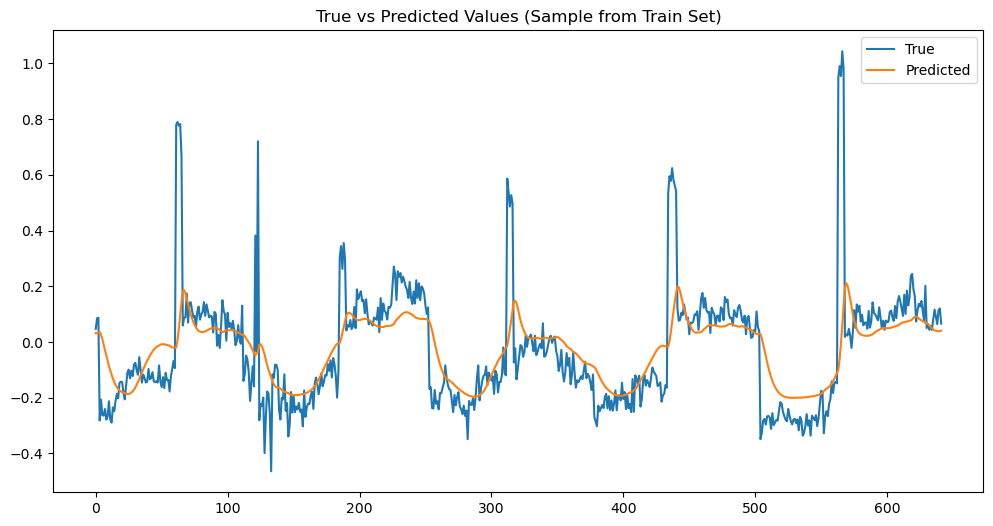

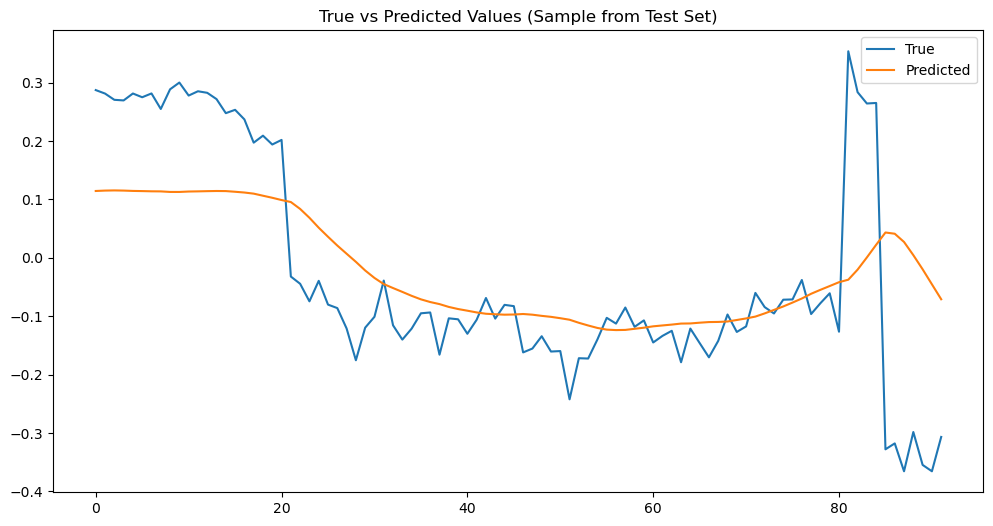

In [62]:
# Plot the results of the model

plt.figure(figsize=(12, 6))
plt.plot(y_train_true[:,0], label='True')
plt.plot(predicted_train[:,0], label='Predicted')
plt.title('True vs Predicted Values (Sample from Train Set)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_true[:,0], label='True')
plt.plot(predicted_test[:,0], label='Predicted')
plt.title('True vs Predicted Values (Sample from Test Set)')
plt.legend()
plt.show()

0.4243369734789392
0.4945054945054945


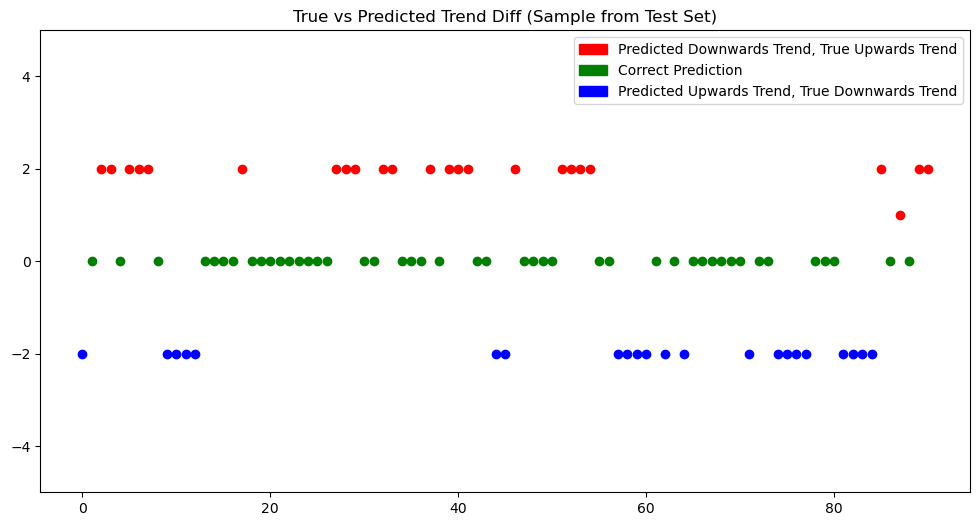

In [63]:
# Compute trend accuracy for test & train set, plot computed trends

accuracy_trend_train = [y_train_true_trend[i] == predicted_train_trend[i] for i in range(len(predicted_train_trend))]
accuracy_trend_test = [y_test_true_trend[i] == predicted_test_trend[i] for i in range(len(predicted_test_trend))]
print(np.sum(accuracy_trend_train)/len(accuracy_trend_train))
print(np.sum(accuracy_trend_test)/len(accuracy_trend_test))

plt.figure(figsize=(12, 6))
for i in range(len(y_test_true_trend)):
  if y_test_true_trend[i] == predicted_test_trend[i]:
    plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='g')
  elif y_test_true_trend[i] > predicted_test_trend[i]:
    plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='r')
  else:
    plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='b')
red_patch = mpatches.Patch(color='red', label='Predicted Downwards Trend, True Upwards Trend')
green_patch = mpatches.Patch(color='green', label='Correct Prediction')
blue_patch = mpatches.Patch(color='blue', label='Predicted Upwards Trend, True Downwards Trend')
plt.ylim(-5,5)
plt.title('True vs Predicted Trend Diff (Sample from Test Set)')
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

In [64]:
# Smooth out signal by computing Moving Averages

y_test_true_ma_adjusted = [np.mean(y_test_true[i,:]) for i in range(len(y_test_true))]
predicted_test_ma_adjusted = [np.mean(predicted_test[i,:,:]) for i in range(len(predicted_test))]

y_train_true_ma_adjusted = [np.mean(y_train_true[i,:]) for i in range(len(y_train_true))]
predicted_train_ma_adjusted = [np.mean(predicted_train[i,:,:]) for i in range(len(predicted_train))]

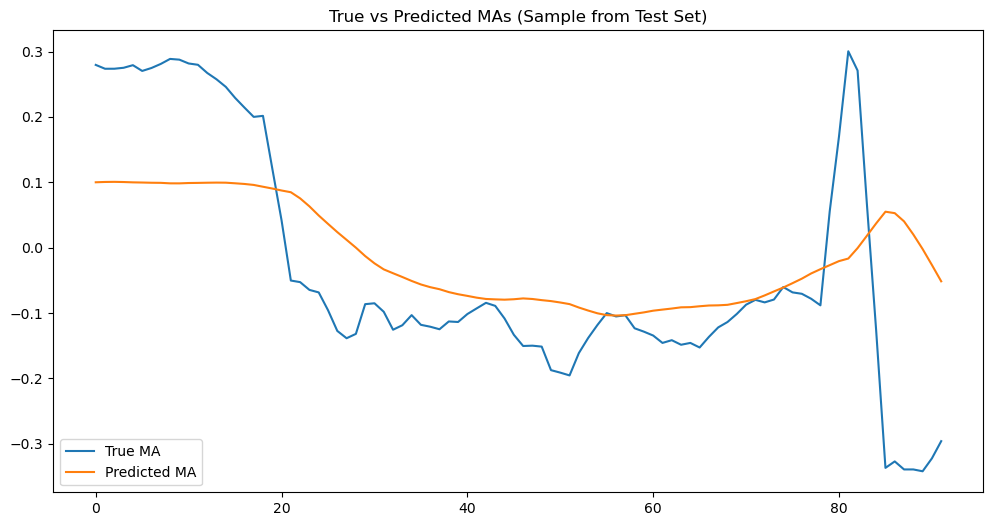

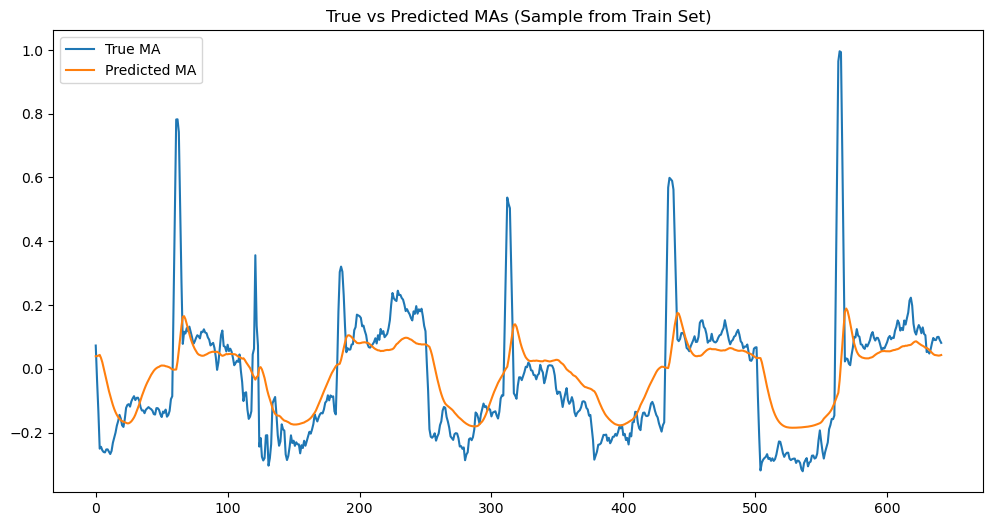

In [65]:
# Plot MAs

plt.figure(figsize=(12, 6))
plt.plot(y_test_true_ma_adjusted, label='True MA')
plt.plot(predicted_test_ma_adjusted, label='Predicted MA')
plt.title('True vs Predicted MAs (Sample from Test Set)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_train_true_ma_adjusted, label='True MA')
plt.plot(predicted_train_ma_adjusted, label='Predicted MA')
plt.title('True vs Predicted MAs (Sample from Train Set)')
plt.legend()
plt.show()

# Random Forest and XGBoost Regressors Data Preparation

After the LSTM Encoder Decoder Model that leverages neural networks, we test the same assumptions under two other popular methods in time series forecasting: tree-based models and gradient boosting methods. To test these approaches, we rely on existing literature for time series prediction and construct a Random Forest Regressor and XGBoost model. These models do not work with time series data out of the box, therefore we reconstruct our input to contain the previous 5 data points for each point in the dataset as features. The labels are the actual values. Again, we use a train test split to evaluate results.

| Day | lag_5 | lag_4 | lag_3 | lag_2 | lag_1 | current |
|--|--|--|--|--|--|--|
|1|10|11|13|12|14|16|
|2|11|13|12|14|16|17|
|3|13|12|14|16|17|15|

.\
.\
.

In [66]:
# Create lagged features

def create_lagged_features(series, lags=5):
    spread = pd.Series(series, name='spread')
    df = pd.DataFrame(spread)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['spread'].shift(lag)
    df.dropna(inplace=True)
    return df

lags = 5
lagged_df = create_lagged_features(data, lags=lags)

# Split into train and test sets

X = lagged_df.drop(columns=['spread'])
y = lagged_df['spread']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train and predict with Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train and predict with XGBoost

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


# Evaluation of the Models

We compute the RMSEs and MAEs of both models and save them. We plot the predictions against the actual values first, then compute trend and calculate the directional accuracy. We store all results in our evaluation results dictionary.

Random Forest MAE: 0.05942347477945964
XGBoost MAE: 0.07207719222050962


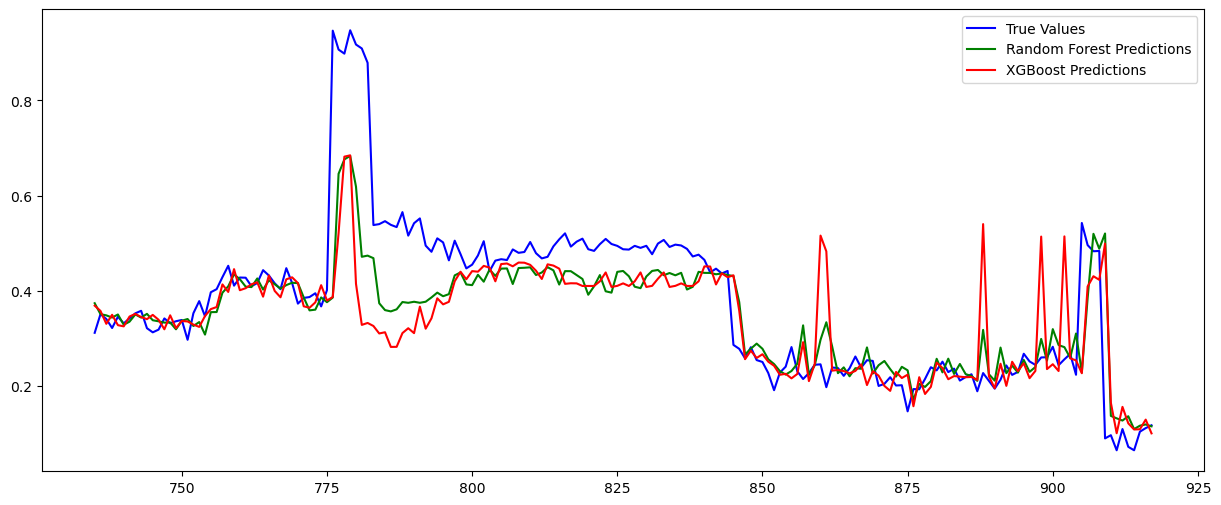

In [67]:
# Evaluate Random Forest

rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f'Random Forest MAE: {rf_mae}')

# Evaluate XGBoost

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
print(f'XGBoost MAE: {xgb_mae}')

# Example: Plot the results

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='True Values', color='blue')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='green')
plt.plot(y_test.index, xgb_predictions, label='XGBoost Predictions', color='red')
plt.legend()
plt.show()


In [68]:
# Random Forest Directional Accuracy

trend_rf = []
for i in range(1, len(y_test)-10):
    if rf_predictions[i] > y_test.iloc[i-1]:
        trend_rf.append(1)
    elif rf_predictions[i] < y_test.iloc[i-1]:
        trend_rf.append(-1)
    else:
        trend_rf.append(0)

trend_rf_true = []
for i in range(1, len(y_test)-10):
    if np.mean(y_test.iloc[i:i+10]) > y_test.iloc[i-1]:
        trend_rf_true.append(1)
    elif np.mean(y_test.iloc[i:i+10]) < y_test.iloc[i-1]:
        trend_rf_true.append(-1)
    else:
        trend_rf_true.append(0)

accuracy_trend = [trend_rf[i] == trend_rf_true[i] for i in range(len(trend_rf))] 
print(np.sum(accuracy_trend)/len(accuracy_trend))


0.6453488372093024


In [69]:
# XGBoost Directional Accuracy

trend_xgb = []
for i in range(1, len(y_test)-10):
    if xgb_predictions[i] > y_test.iloc[i-1]:
        trend_xgb.append(1)
    elif xgb_predictions[i] < y_test.iloc[i-1]:
        trend_xgb.append(-1)
    else:
        trend_xgb.append(0)

trend_xgb_true = []
for i in range(1, len(y_test)-10):
    if np.mean(y_test.iloc[i:i+10]) > y_test.iloc[i-1]:
        trend_xgb_true.append(1)
    elif np.mean(y_test.iloc[i:i+10]) < y_test.iloc[i-1]:
        trend_xgb_true.append(-1)
    else:
        trend_xgb_true.append(0)

accuracy_trend = [trend_xgb[i] == trend_xgb_true[i] for i in range(len(trend_xgb))] 
print(np.sum(accuracy_trend)/len(accuracy_trend))


0.6569767441860465


# ARIMA

Since our tests with gradient boosting and tree algorithms yield mixed results, we experiment with ARIMA (Auto-Regressive Integrated Moving Verage). ARIMA models seem like a good fit for our case because:
1. The model assumes a changing variable that regresses on its own lagged values
2. Uses the difference in series values which allows the data to become stationary
3. Incorporates a moving avergae to calculate residual errors

ARIMA models have three parameters which we need to optimize:
- **p** → Number of lag observations
- **d** → The number of times the observations are differenced
- **q** → Size of the rolling window for MAs

We adopt a grid-search like approach to optimize the parameters and compute success metrics.

Finding optimal ARIMA parameters for IXUS and VXUS...
Best ARIMA parameters (p, d, q): (1, 0, 2)
Sample 3-day forecast:
[-0.24768334 -0.21938438 -0.19047593]


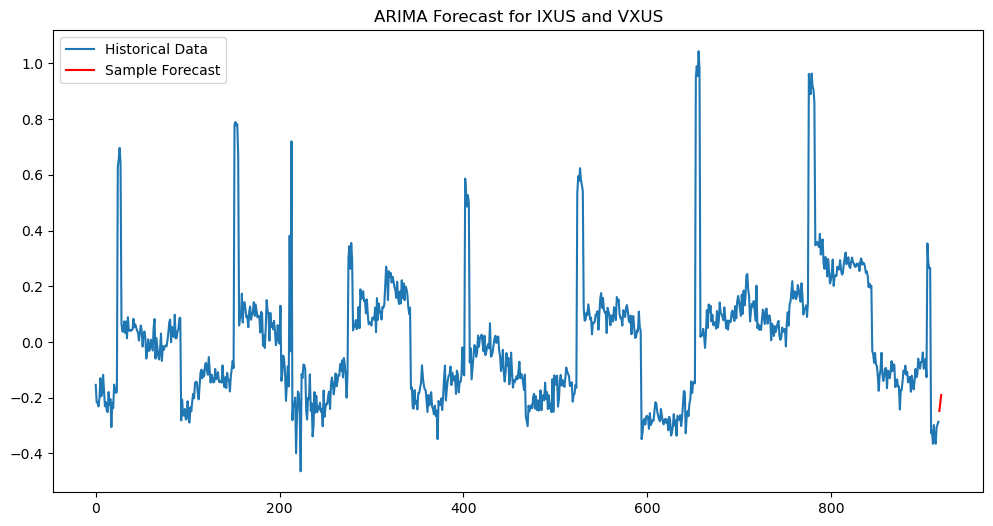

In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
import warnings
import pickle

warnings.filterwarnings("ignore")

# Prepare data for ARIMA
arima_data = spread.values

# Function to find optimal ARIMA parameters
def optimize_arima(data, p_range, d_range, q_range):
    best_aic = float("inf")
    best_params = None
    for p, d, q in product(p_range, d_range, q_range):
        try:
            model = ARIMA(data, order=(p, d, q))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q)
        except:
            continue
    return best_params

# Find optimal parameters
print(f"Finding optimal ARIMA parameters for {ticker_1} and {ticker_2}...")
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
best_params = optimize_arima(arima_data, p_range, d_range, q_range)
print(f"Best ARIMA parameters (p, d, q): {best_params}")

# Fit ARIMA model on the entire dataset
model = ARIMA(arima_data, order=best_params)
results = model.fit()

# Save the model
with open(f'../../data/ch3_{ticker_1}_{ticker_2}_arima.pkl', 'wb') as f:
    pickle.dump(results, f)

# Make a sample 3-day forecast
forecast = results.forecast(steps=3)
print("Sample 3-day forecast:")
print(forecast)

# Plot the entire time series and the sample forecast
plt.figure(figsize=(12, 6))
plt.plot(range(len(arima_data)), arima_data, label='Historical Data')
plt.plot(range(len(arima_data), len(arima_data) + 3), forecast, color='red', label='Sample Forecast')
plt.title(f'ARIMA Forecast for {ticker_1} and {ticker_2}')
plt.legend()
plt.show()

# Add ARIMA results to evaluation_dict
# evaluation_dict["ARIMA Sample Forecast"] = forecast.tolist()
# evaluation_dict["ARIMA Best Parameters"] = best_params

# Prophet Model

Lastly, as a wildcard choice, we test Meta's Prophet model which is heavily utilized in time series forecasting. The catch is that Prophet is mainly popular for time series data with seasonality. We can't assume our spread to be stochastically seasonal but it would be a fair hypothesis to expect oscillations around the mean. Although not the same as seasonality, this implies mildly similar stochastical characteristics. In addition, Prophet provides upper and lower bounds for predictions, trend lines and even changepoints for trend as part of the model, which may prove useful in our study.

Unfortunately computing the accuracy of the model leads us to discard this option completely as the prediction accuracy is too low to produce reliable indicators of trend. In hindsight, this is to be expected since our data has no seasonal characteristics and no extra information other than the past values of the time series. The model struggles with establishing a causal relationship between the features and the trend or seasonal patterns. Nonetheless we compute accuracy metrics, plot components and trend, and save results.

19:44:18 - cmdstanpy - INFO - Chain [1] start processing
19:44:18 - cmdstanpy - INFO - Chain [1] done processing


                                           ds         y     lag_1     lag_2  \
Timestamp                                                                     
2019-05-28 04:00:00+00:00 2019-05-28 04:00:00 -0.230972 -0.175432 -0.118219   
2019-05-29 04:00:00+00:00 2019-05-29 04:00:00 -0.215850 -0.230972 -0.175432   
2019-05-30 04:00:00+00:00 2019-05-30 04:00:00 -0.247418 -0.215850 -0.230972   
2019-05-31 04:00:00+00:00 2019-05-31 04:00:00 -0.251773 -0.247418 -0.215850   
2019-06-03 04:00:00+00:00 2019-06-03 04:00:00 -0.179787 -0.251773 -0.247418   

                              lag_3     lag_4     lag_5     lag_6     lag_7  \
Timestamp                                                                     
2019-05-28 04:00:00+00:00 -0.180031 -0.195153 -0.129648 -0.202923 -0.231320   
2019-05-29 04:00:00+00:00 -0.118219 -0.180031 -0.195153 -0.129648 -0.202923   
2019-05-30 04:00:00+00:00 -0.175432 -0.118219 -0.180031 -0.195153 -0.129648   
2019-05-31 04:00:00+00:00 -0.230972 -0.175432 -0.11

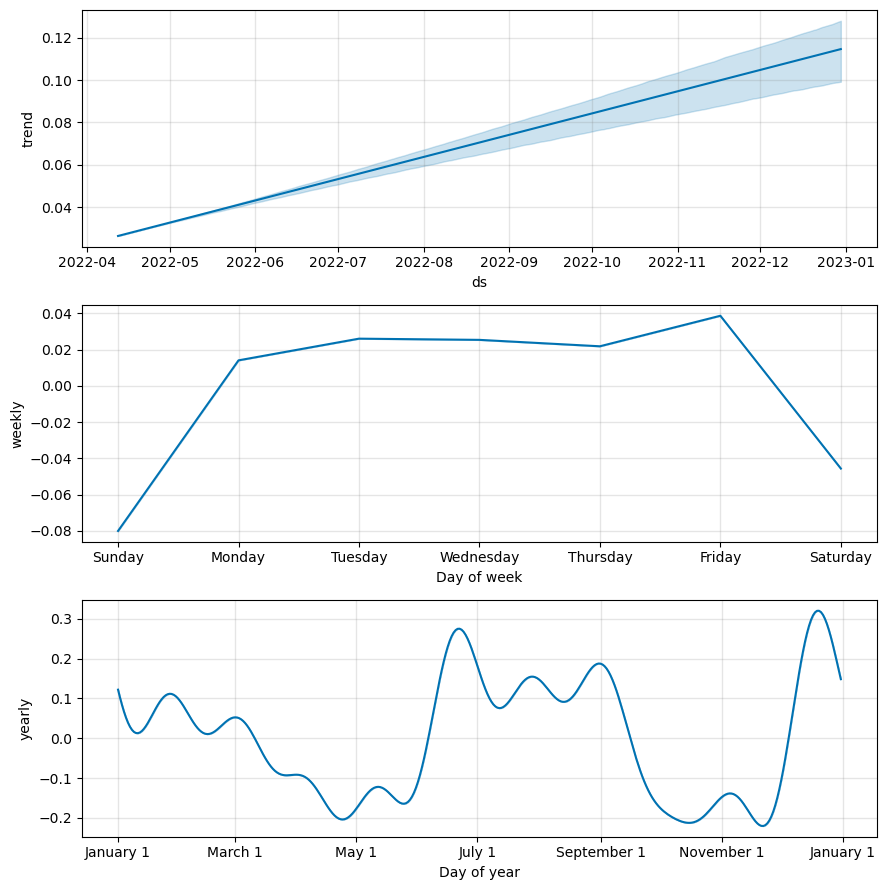

0.24369011888655304
0.15294749432762866


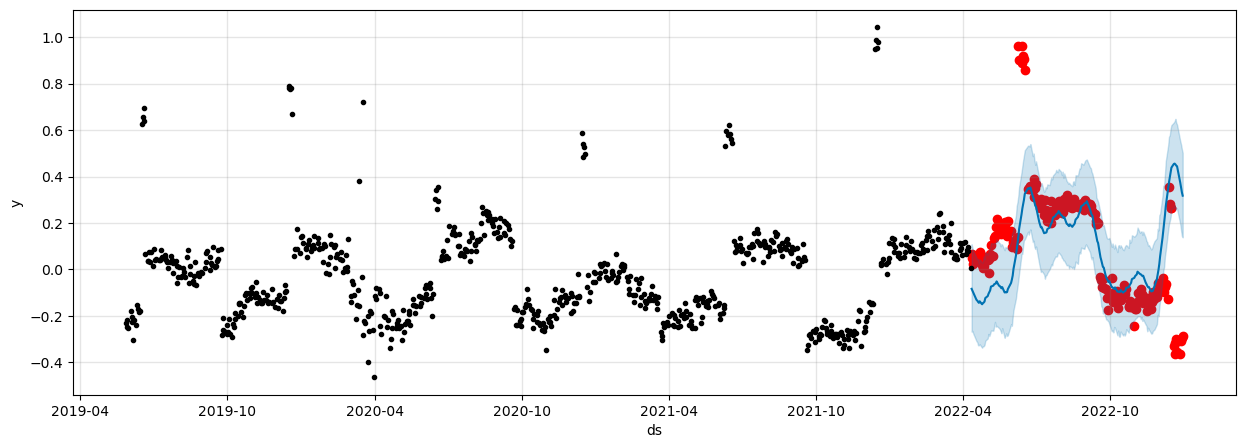

In [71]:
# Construct Prophet model

prophet_df = pd.DataFrame({'ds': pd.to_datetime(ticker_series_1.index), 'y': spread})
for lag in range(1, 11):
    prophet_df[f'lag_{lag}'] = prophet_df['y'].shift(lag)
prophet_df.dropna(inplace=True)

# Prepare the data

prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)
print(prophet_df.head())

train_size = int(len(prophet_df) * 0.8)
train_prophet_df = prophet_df.iloc[:train_size]
test_prophet_df = prophet_df.iloc[train_size:]

# Initialize and fit the model

prophet_model = Prophet()
prophet_model.fit(train_prophet_df)

# Make future dataframe and predictions

forecast = prophet_model.predict(test_prophet_df)

# Show forecast

fig = prophet_model.plot_components(forecast)
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_prophet_df['ds'], test_prophet_df['y'], color='r')
fig = prophet_model.plot(forecast, ax=ax)
print(np.sqrt(mean_squared_error(y_true=test_prophet_df['y'],
                   y_pred=forecast['yhat'])))

print(mean_absolute_error(y_true=test_prophet_df['y'],
                   y_pred=forecast['yhat']))


# Rolling Linear Regression Trend

So far, all of the results we have are inconclusive. This leads us to zoom out and look for a different approach. There are a couple of important learnings at this point:
1. We want to utilize the most recent trend of the time series to generate signals.
2. Our data does not necessarily have seasonal characteristics.
3. For short rolling windows, our data is not necessarily stationary or homoskedastic.
4. We are constrained by the fact that the only information we have regarding the time series is price points and nothing else. This significantly limits our hand when working with complex models.

Based on these learnings, we come up with a simple blend of rolling windows and machine learning. I call it the Rolling Linear Regression Trend.

This mashup technique is simple:
1. For each point in time, take the last 10 price points.
2. Fith them into a linear regression model.
4. Calculate confidence of the model.
5. If the confidence of the model is above a certain threshold, generate signals if the data already satisfies other trading criteria.


Results for R² threshold 0.4:
Accuracy: 81.39%
Total signals: 274
Correct predictions: 223
Accuracy of generated signals: 81.39%
Average R² Confidence: 0.2841

Results for R² threshold 0.5:
Accuracy: 82.23%
Total signals: 197
Correct predictions: 162
Accuracy of generated signals: 82.23%
Average R² Confidence: 0.2841

Results for R² threshold 0.6:
Accuracy: 86.72%
Total signals: 128
Correct predictions: 111
Accuracy of generated signals: 86.72%
Average R² Confidence: 0.2841


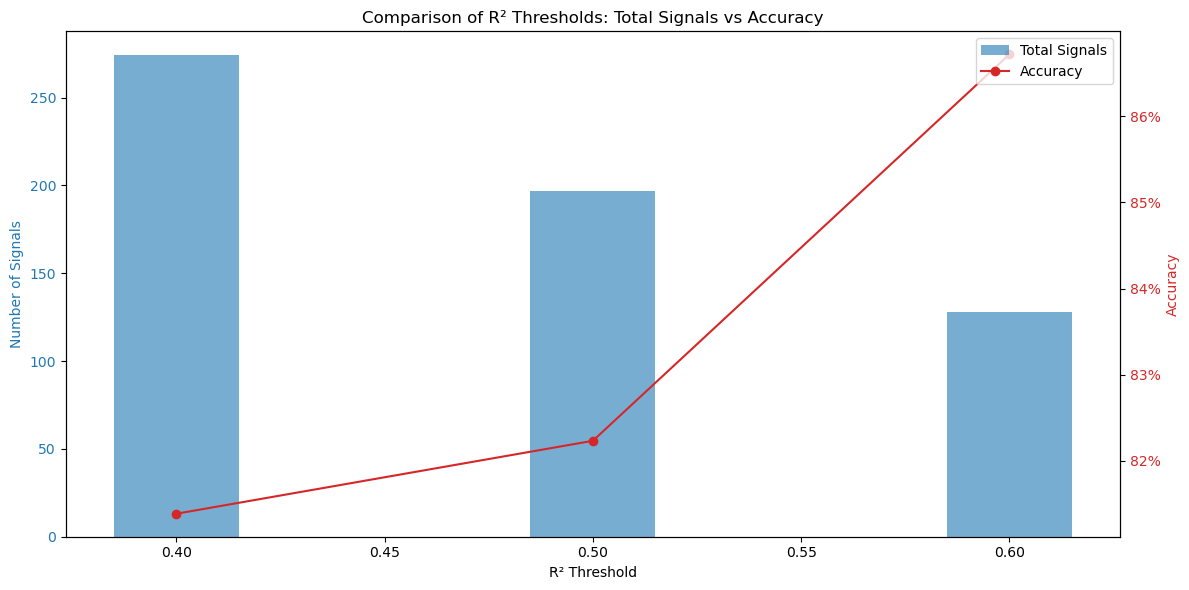

Threshold comparison plot with thin bars created.

Best performing threshold: 0.6


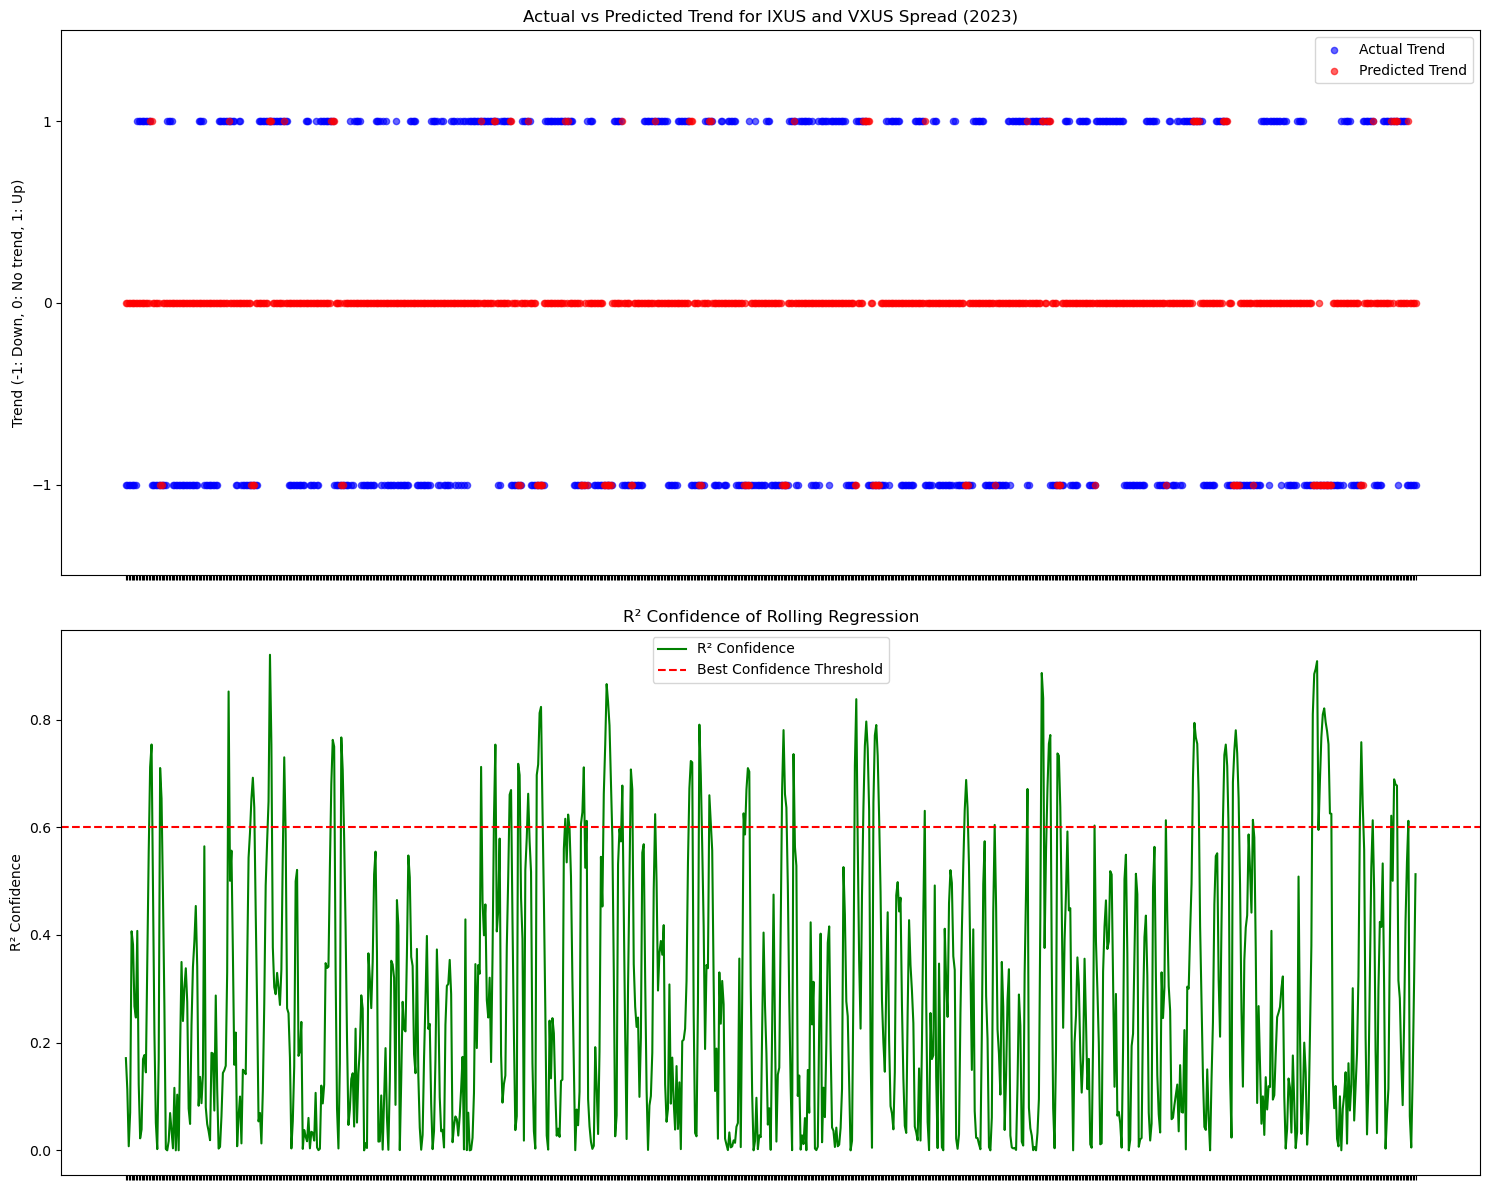

Actual vs Predicted Trend scatter plot created without x-axis labels.
Threshold optimization completed.


In [72]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt

def rolling_regression_trend_with_confidence(data, window_size=10, forecast_days=3, r2_threshold=0.5):
    trends = []
    confidences = []
    for i in range(window_size, len(data) - forecast_days + 1):
        X = np.arange(window_size).reshape(-1, 1)
        y = data[i-window_size:i]
        model = LinearRegression()
        model.fit(X, y)
        
        r2 = r2_score(y, model.predict(X))
        
        if r2 > r2_threshold:
            trend = 1 if model.coef_[0] > 0 else -1 if model.coef_[0] < 0 else 0
        else:
            trend = 0
        
        trends.append(trend)
        confidences.append(r2)
    return np.array(trends), np.array(confidences)

def actual_trend(data, window_size=10, forecast_days=3):
    trends = []
    for i in range(window_size, len(data) - forecast_days + 1):
        past_avg = np.mean(data[i-window_size:i])
        future_avg = np.mean(data[i:i+forecast_days])
        trend = 1 if future_avg > past_avg else -1 if future_avg < past_avg else 0
        trends.append(trend)
    return np.array(trends)

def evaluate_threshold(data, actual_trends, r2_threshold):
    predicted_trends, confidences = rolling_regression_trend_with_confidence(data, r2_threshold=r2_threshold)
    
    non_zero_predictions = predicted_trends != 0
    accuracy = accuracy_score(actual_trends[non_zero_predictions], predicted_trends[non_zero_predictions])
    
    total_predictions = sum(predicted_trends != 0)
    correct_predictions = sum((predicted_trends == actual_trends) & (predicted_trends != 0))
    accuracy_percentage = (correct_predictions / total_predictions * 100) if total_predictions > 0 else 0
    
    return {
        'threshold': r2_threshold,
        'accuracy': accuracy,
        'total_signals': total_predictions,
        'correct_predictions': correct_predictions,
        'accuracy_percentage': accuracy_percentage,
        'average_confidence': np.mean(confidences)
    }

# Ensure data and index have the same length
min_length = min(len(data), len(spread.index))
data = data[:min_length]
dates = spread.index[:min_length]

# Calculate actual trends
actual_trends = actual_trend(data)

# Test different thresholds
thresholds = [0.4, 0.5, 0.6]
results = []

for threshold in thresholds:
    result = evaluate_threshold(data, actual_trends, threshold)
    results.append(result)
    print(f"\nResults for R² threshold {threshold}:")
    print(f"Accuracy: {result['accuracy']:.2%}")
    print(f"Total signals: {result['total_signals']}")
    print(f"Correct predictions: {result['correct_predictions']}")
    print(f"Accuracy of generated signals: {result['accuracy_percentage']:.2f}%")
    print(f"Average R² Confidence: {result['average_confidence']:.4f}")

# Extract data from results for plotting
total_signals = [r['total_signals'] for r in results]
accuracies = [r['accuracy'] for r in results]

# Plot comparison of thresholds
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total signals on the left y-axis with thinner bars
color = 'tab:blue'
bar_width = 0.03  # Adjust this value to make bars thinner or thicker
ax1.set_xlabel('R² Threshold')
ax1.set_ylabel('Number of Signals', color=color)
ax1.bar(thresholds, total_signals, width=bar_width, alpha=0.6, color=color, label='Total Signals')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(thresholds, accuracies, color=color, marker='o', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Set the accuracy y-axis to percentage format
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Title and legend
plt.title('Comparison of R² Thresholds: Total Signals vs Accuracy')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Adjust layout and display
plt.tight_layout()
plt.show()

print("Threshold comparison plot with thin bars created.")

# Plot trends and confidence for the best performing threshold
best_threshold = max(results, key=lambda x: x['accuracy'])['threshold']
print(f"\nBest performing threshold: {best_threshold}")

predicted_trends, confidences = rolling_regression_trend_with_confidence(data, r2_threshold=best_threshold)

# Ensure all arrays have the same length for plotting
min_length = min(len(predicted_trends), len(actual_trends), len(dates) - 13)
predicted_trends = predicted_trends[:min_length]
actual_trends = actual_trends[:min_length]
confidences = confidences[:min_length]
plot_dates = dates[13:13+min_length]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Scatter plot for actual trends
ax1.scatter(plot_dates, actual_trends, label='Actual Trend', color='blue', alpha=0.6, s=20)
# Scatter plot for predicted trends
ax1.scatter(plot_dates, predicted_trends, label='Predicted Trend', color='red', alpha=0.6, s=20)

ax1.set_title(f'Actual vs Predicted Trend for {ticker_1} and {ticker_2} Spread (2023)')
ax1.set_ylabel('Trend (-1: Down, 0: No trend, 1: Up)')
ax1.legend()
ax1.set_ylim(-1.5, 1.5)  # Set y-axis limits to better show the discrete values
ax1.set_yticks([-1, 0, 1])  # Set y-axis ticks to show only the possible trend values

# Plot for R² confidence
ax2.plot(plot_dates, confidences, label='R² Confidence', color='green')
ax2.axhline(y=best_threshold, color='r', linestyle='--', label='Best Confidence Threshold')
ax2.set_title('R² Confidence of Rolling Regression')
ax2.set_ylabel('R² Confidence')
ax2.legend()

# Remove x-axis labels from both subplots
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Adjust layout to remove extra space
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)  # Reduce space between subplots

plt.show()

print("Actual vs Predicted Trend scatter plot created without x-axis labels.")

print("Threshold optimization completed.")

# Generating Signals and P&L with RLRT

Here we generate a P&L to assess the success of RLRT. We generate signals based on the following conditions:
1. If the current price point is above 1 standard deviation of the mean AND RLRT indicates a downward signal, we generate a short signal.
2. If the current price point is below 1 standard deviation of the mean AND RLRT indicates an upward signal, we generate a long signal.
3. If the current price point is withing 1 standard deviation of the mean AND RLRT indicates a downward signal, we generate an exit short signal.
4. If the current price point is withing 1 standard deviation of the mean AND RLRT indicates an upward signal, we generate an exit long signal.

Here are the interpretations of the signals:
- Long: If position is short or none, take long position.
- Short: If position is long or none, take short position.
- Exit Long: If position is long, exit position to none.
- Exit Short: If position is short, exit position to none.

Based on this criteria, we start with an initial budget of $100.000 and calculate annualized returns, Sharpe ratio and maximum drawdowns. Our plots display the progression of the budget over time and the exact points in time where signals are generated.

                                                Date    Spread  \
Timestamp                                                        
2019-05-13 04:00:00+00:00  2019-05-13 04:00:00+00:00  0.205755   
2019-05-14 04:00:00+00:00  2019-05-14 04:00:00+00:00  0.163966   
2019-05-15 04:00:00+00:00  2019-05-15 04:00:00+00:00  0.164844   
2019-05-16 04:00:00+00:00  2019-05-16 04:00:00+00:00  0.154466   
2019-05-17 04:00:00+00:00  2019-05-17 04:00:00+00:00  0.173304   
2019-05-20 04:00:00+00:00  2019-05-20 04:00:00+00:00  0.221911   
2019-05-21 04:00:00+00:00  2019-05-21 04:00:00+00:00  0.178458   
2019-05-22 04:00:00+00:00  2019-05-22 04:00:00+00:00  0.188489   
2019-05-23 04:00:00+00:00  2019-05-23 04:00:00+00:00  0.229492   
2019-05-24 04:00:00+00:00  2019-05-24 04:00:00+00:00  0.191540   
2019-05-28 04:00:00+00:00  2019-05-28 04:00:00+00:00  0.154697   
2019-05-29 04:00:00+00:00  2019-05-29 04:00:00+00:00  0.164729   
2019-05-30 04:00:00+00:00  2019-05-30 04:00:00+00:00  0.143788   
2019-05-31

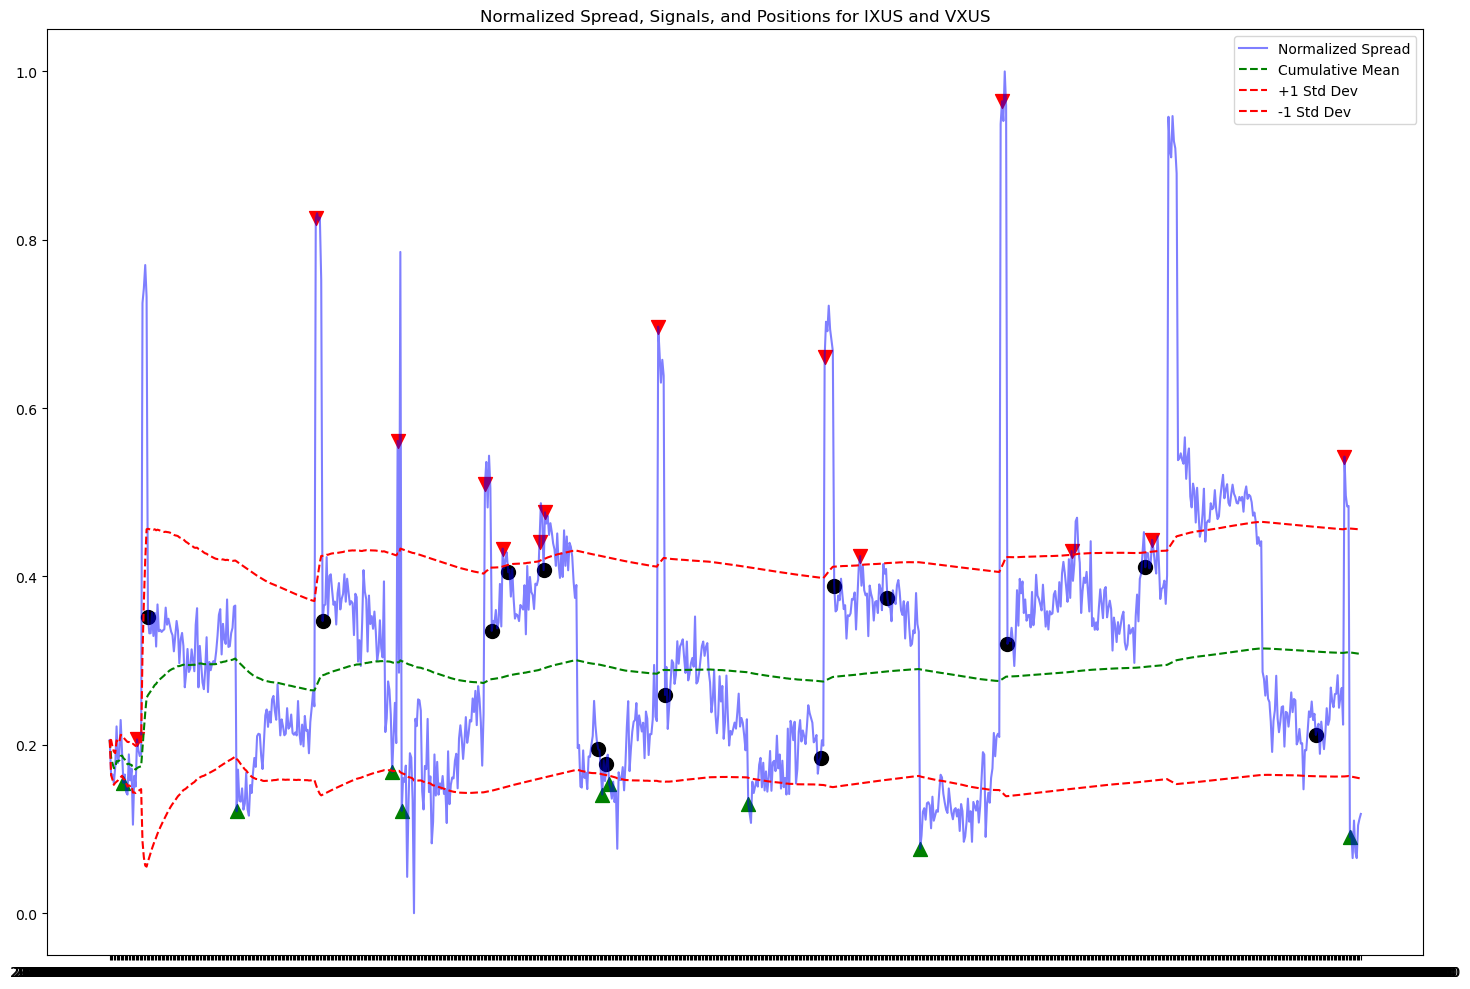

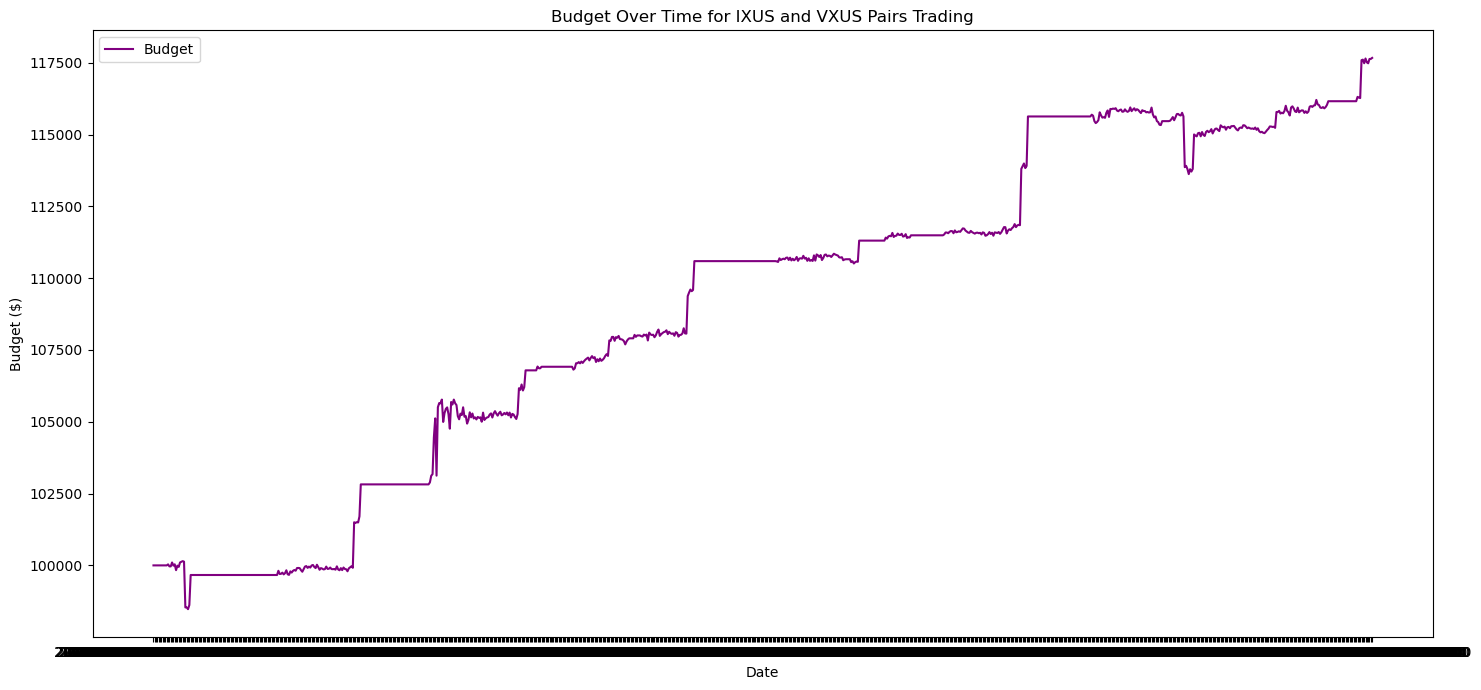


Signal Statistics:
Total Signals: 302
Long Signals: 109
Short Signals: 113
Exit Long Signals: 49
Exit Short Signals: 31

Position Statistics:
Long Positions: 294
Short Positions: 281
Neutral Positions: 343

Trading Strategy Statistics:
Time Period: 2019-05-13 to 2022-12-30 (3.63 years)
Starting Budget: $100000.00
Ending Budget: $117669.33
Total Return: 17.67%
Annualized Return: 4.58%
Maximum Drawdown: -2.00%
Sharpe Ratio: 1.40
Budget-based return calculation completed.


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
initial_budget = 100000
dates = spread.index

# Define window size
window_size = 10

# Initialize lists for signals, positions, and budget
signals = ['None'] * len(data)
positions = [0] * len(data)
budgets = [initial_budget] * len(data)

# Initialize lists to keep track of cumulative mean and std
cumulative_mean = np.zeros(len(data))
cumulative_std = np.zeros(len(data))

# Create a new list for padded predictions
padded_predictions = [None] * window_size + list(predicted_trends)
if len(padded_predictions) < len(data):
    padded_predictions.extend([None] * (len(data) - len(padded_predictions)))
else:
    padded_predictions = padded_predictions[:len(data)]

# Iterate through the data to calculate cumulative mean and std, generate signals, and update budget
for i in range(len(data)):
    if i < window_size:
        cumulative_mean[i] = np.mean(data[:i+1])
        cumulative_std[i] = np.std(data[:i+1]) if i > 0 else 0
        continue
    
    cumulative_mean[i] = np.mean(data[:i+1])
    cumulative_std[i] = np.std(data[:i+1])
    
    spread_value = data[i]
    trend_prediction = padded_predictions[i] if padded_predictions[i] is not None else 0
    
    if spread_value > cumulative_mean[i] + cumulative_std[i]:
        if trend_prediction <= 0:  # 0 or -1
            signals[i] = "Short"
        else:
            signals[i] = "None"
    elif spread_value < cumulative_mean[i] - cumulative_std[i]:
        if trend_prediction >= 0:  # 0 or 1
            signals[i] = "Long"
        else:
            signals[i] = "None"
    else:  # Within 1 standard deviation
        if trend_prediction == 1:
            signals[i] = "Exit Short"
        elif trend_prediction == -1:
            signals[i] = "Exit Long"
        else:
            signals[i] = "None"
    
    # Update position and budget based on signal
    current_position = positions[i-1]
    if signals[i] == "Short" and current_position != -1:
        # Close any existing long position
        if current_position == 1:
            returns = (ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                      (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1)
            budgets[i] = budgets[i-1] * (1 + returns)
        positions[i] = -1
    elif signals[i] == "Long" and current_position != 1:
        # Close any existing short position
        if current_position == -1:
            returns = -((ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                        (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1))
            budgets[i] = budgets[i-1] * (1 + returns)
        positions[i] = 1
    elif (signals[i] == "Exit Short" and current_position == -1) or (signals[i] == "Exit Long" and current_position == 1):
        # Close position
        returns = current_position * ((ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                                      (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1))
        budgets[i] = budgets[i-1] * (1 + returns)
        positions[i] = 0
    else:
        positions[i] = current_position
        
    # Update budget based on current position
    if current_position != 0:
        returns = current_position * ((ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                                      (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1))
        budgets[i] = budgets[i-1] * (1 + returns)
    else:
        budgets[i] = budgets[i-1]

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Date': dates,
    'Spread': data,
    'Predicted_Trend': padded_predictions,
    'Signal': signals,
    'Position': positions,
    'Budget': budgets,
    ticker_1: ticker_series_1,
    ticker_2: ticker_series_2
})

# Calculate returns and other metrics
results_df['Daily_Return'] = results_df['Budget'].pct_change()
results_df['Cumulative_Return'] = results_df['Budget'] / initial_budget - 1

# Calculate maximum drawdown
roll_max = results_df['Budget'].cummax()
daily_drawdown = results_df['Budget'] / roll_max - 1.0
max_drawdown = daily_drawdown.min()

# Display results
print(results_df.head(20))
print(results_df.tail(20))

# Plot the spread, signals, and positions
plt.figure(figsize=(15, 10))
plt.plot(dates, data, label='Normalized Spread', color='blue', alpha=0.5)
plt.plot(dates, cumulative_mean, color='green', linestyle='--', label='Cumulative Mean')
plt.plot(dates, cumulative_mean + cumulative_std, color='red', linestyle='--', label='+1 Std Dev')
plt.plot(dates, cumulative_mean - cumulative_std, color='red', linestyle='--', label='-1 Std Dev')

# Plot positions
for i in range(1, len(positions)):
    if positions[i] != positions[i-1]:
        if positions[i] == 1:
            plt.scatter(dates[i], data[i], color='green', marker='^', s=100)
        elif positions[i] == -1:
            plt.scatter(dates[i], data[i], color='red', marker='v', s=100)
        elif positions[i] == 0:
            plt.scatter(dates[i], data[i], color='black', marker='o', s=100)

plt.title(f'Normalized Spread, Signals, and Positions for {ticker_1} and {ticker_2}')
plt.legend()
plt.tight_layout()
plt.show()

# Plot budget over time
plt.figure(figsize=(15, 7))
plt.plot(dates, budgets, label='Budget', color='purple')
plt.title(f'Budget Over Time for {ticker_1} and {ticker_2} Pairs Trading')
plt.xlabel('Date')
plt.ylabel('Budget ($)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print statistics
total_signals = len([s for s in signals if s != "None"])
long_signals = signals.count("Long")
short_signals = signals.count("Short")
exit_long_signals = signals.count("Exit Long")
exit_short_signals = signals.count("Exit Short")

print(f"\nSignal Statistics:")
print(f"Total Signals: {total_signals}")
print(f"Long Signals: {long_signals}")
print(f"Short Signals: {short_signals}")
print(f"Exit Long Signals: {exit_long_signals}")
print(f"Exit Short Signals: {exit_short_signals}")

print("\nPosition Statistics:")
print(f"Long Positions: {positions.count(1)}")
print(f"Short Positions: {positions.count(-1)}")
print(f"Neutral Positions: {positions.count(0)}")

start_date = pd.to_datetime(results_df['Date'].iloc[0])
end_date = pd.to_datetime(results_df['Date'].iloc[-1])

# Calculate the number of years
years = (end_date - start_date).days / 365.25

# Calculate total return
total_return = (budgets[-1] / initial_budget) - 1

# Calculate annualized return
annualized_return = (1 + total_return) ** (1 / years) - 1

print(f"\nTrading Strategy Statistics:")
print(f"Time Period: {start_date.date()} to {end_date.date()} ({years:.2f} years)")
print(f"Starting Budget: ${initial_budget:.2f}")
print(f"Ending Budget: ${budgets[-1]:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {np.sqrt(252) * results_df['Daily_Return'].mean() / results_df['Daily_Return'].std():.2f}")

print("Budget-based return calculation completed.")

In [74]:
spread_mean = np.mean(data)
spread_stdev = np.std(data)

with open('../../data/ch2_spread_stats.pkl', 'wb') as f:
    pickle.dump([spread_mean, spread_stdev], f)